# Crystal Ball Function

The Crystal Ball function combines a Gaussian core with a power-law tail. It is commonly used in particle physics to model detector resolution effects where the core is Gaussian but radiation or other effects create an asymmetric tail.

In [1]:
import fitle as fl
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

## Mathematical Definition

The Crystal Ball function is defined as:

$$
f_{\text{CB}}(x; \alpha, n, \mu, \sigma) = N \cdot
\begin{cases}
  A \left(B - \frac{x-\mu}{\sigma}\right)^{-n}, & \frac{x-\mu}{\sigma} < -\alpha, \\
  \exp\!\Big(-\frac{1}{2}\big(\frac{x-\mu}{\sigma}\big)^2\Big), & \frac{x-\mu}{\sigma} \ge -\alpha,
\end{cases}
$$

where:
- $\alpha > 0$ is the transition point (in units of $\sigma$) where the Gaussian switches to the power-law tail
- $n > 1$ is the power of the tail
- $\mu$ is the mean
- $\sigma$ is the standard deviation
- $N$ is the normalization constant
- $A = \left(\frac{n}{\alpha}\right)^n \exp\left(-\frac{\alpha^2}{2}\right)$
- $B = \frac{n}{\alpha} - \alpha$

## Implementation Details

The `fitle` implementation is functionally equivalent to:

```python
def crystalball(alpha, n, mu, sigma):
    n_over_alpha = n/alpha
    exp = np.exp(-0.5*alpha ** 2)
    A = (n_over_alpha)**n * exp
    B = n_over_alpha - alpha
    C = n_over_alpha/(n-1) * exp
    D = np.sqrt(0.5*np.pi) * (1 + fl.Model(lambda a: scipy.special.erf(a), [alpha/np.sqrt(2)]))
    N = 1/(sigma*(C + D))

    z = (fl.INPUT - mu)/sigma

    return np.where(z > -alpha, 
              N*np.exp(-0.5*z**2),
              N*A*(B - z)**-n
             )
```

Key implementation notes:
- Uses `np.where()` for piecewise conditions
- The `fl.Model(lambda ..., [...])` constructor wraps arbitrary functions
- Wrapping `scipy.special.erf` in a lambda prevents automatic differentiation and compilation

## Using the Built-in Crystal Ball

In [2]:
# Create a Crystal Ball model with specified parameters
alpha = fl.Param(0.5, 5)('alpha')(1.5)
n = fl.Param(1.1, 20)('n')(5)
mu = fl.Param('mu')(0)
sigma = fl.Param.positive('sigma')(1)

cb = fl.crystalball(alpha, n, mu, sigma)
print(f"Parameters: {[p.name for p in cb.params]}")

Parameters: ['mu', 'sigma', 'alpha', 'n']


## Visualizing the Crystal Ball Shape

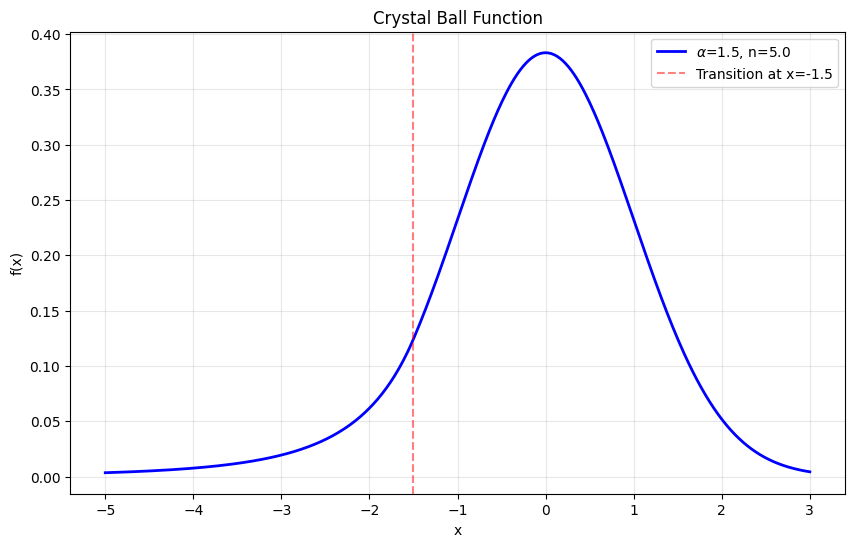

In [3]:
x = np.linspace(-5, 3, 500)

plt.figure(figsize=(10, 6))
plt.plot(x, cb(x), 'b-', linewidth=2, label=f'$\\alpha$={alpha.value}, n={n.value}')

# Show the transition point
transition_x = mu.value - alpha.value * sigma.value
plt.axvline(transition_x, color='r', linestyle='--', alpha=0.5, label=f'Transition at x={transition_x:.1f}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Crystal Ball Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Effect of Parameters

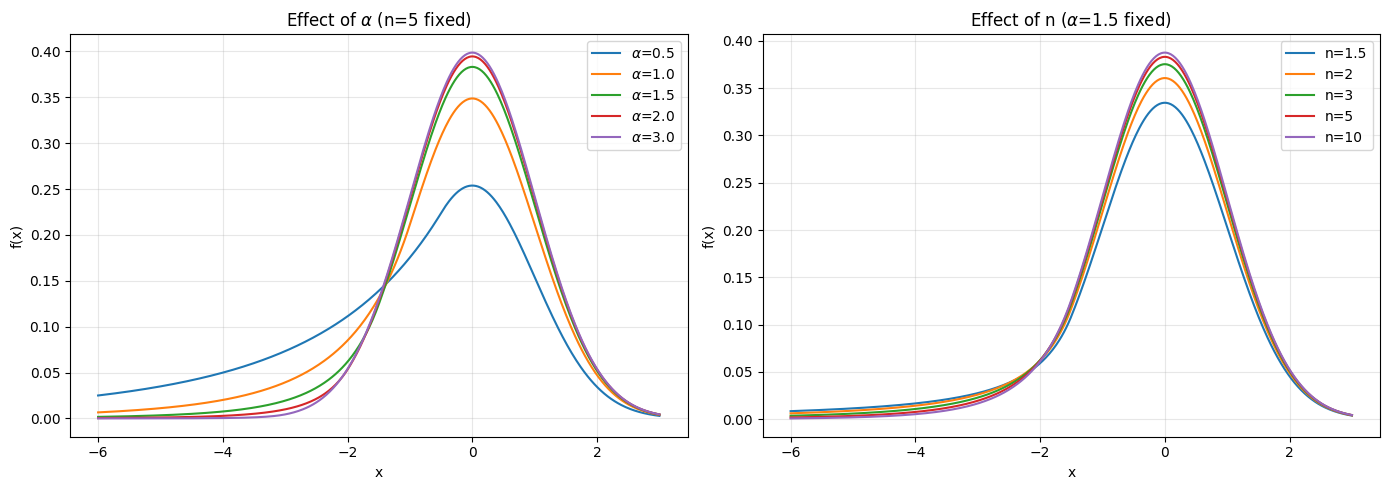

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.linspace(-6, 3, 500)

# Effect of alpha
ax = axes[0]
for alpha_val in [0.5, 1.0, 1.5, 2.0, 3.0]:
    alpha_p = fl.Param('alpha')(alpha_val)
    n_p = fl.Param('n')(5)
    mu_p = fl.Param('mu')(0)
    sigma_p = fl.Param.positive('sigma')(1)
    cb_temp = fl.crystalball(alpha_p, n_p, mu_p, sigma_p)
    ax.plot(x, cb_temp(x), label=f'$\\alpha$={alpha_val}')

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Effect of $\\alpha$ (n=5 fixed)')
ax.legend()
ax.grid(True, alpha=0.3)

# Effect of n
ax = axes[1]
for n_val in [1.5, 2, 3, 5, 10]:
    alpha_p = fl.Param('alpha')(1.5)
    n_p = fl.Param('n')(n_val)
    mu_p = fl.Param('mu')(0)
    sigma_p = fl.Param.positive('sigma')(1)
    cb_temp = fl.crystalball(alpha_p, n_p, mu_p, sigma_p)
    ax.plot(x, cb_temp(x), label=f'n={n_val}')

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Effect of n ($\\alpha$=1.5 fixed)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Fitting with Crystal Ball

In [5]:
# Generate synthetic data using scipy's crystalball
from scipy.stats import crystalball as scipy_cb
np.random.seed(1)

# True parameters
true_mu = 5.0
true_sigma = 0.5
true_alpha = 1.5
true_n = 3.0

# scipy uses (beta, m, loc, scale) where beta=alpha, m=n
data = scipy_cb.rvs(true_alpha, true_n, loc=true_mu, scale=true_sigma, size=5000)

print(f"Generated {len(data)} samples")

Generated 5000 samples


In [6]:
print(np.min(data),np.max(data))

-30.205325407973923 6.824139104126938


In [7]:
# Create model for fitting
alpha_fit = fl.Param(0.5, 5)('alpha')(1.0)
n_fit = fl.Param(1.5, 20)('n')(5.0)
mu_fit = fl.Param(4, 6)('mu')(5.0)
sigma_fit = fl.Param.positive('sigma')(0.3)

cb_fit = fl.crystalball(alpha_fit, n_fit, mu_fit, sigma_fit)

# Fit using unbinned NLL
cost = fl.Cost.NLL(data)
result = fl.fit(cb_fit | cost, numba=False, grad=False)
result

<FitResult fval=4768.402, success=True>
mu: 5.002 ± 0.012
sigma: 0.4932 ± 0.0094
alpha: 1.544 ± 0.076
n: 2.692 ± 0.24

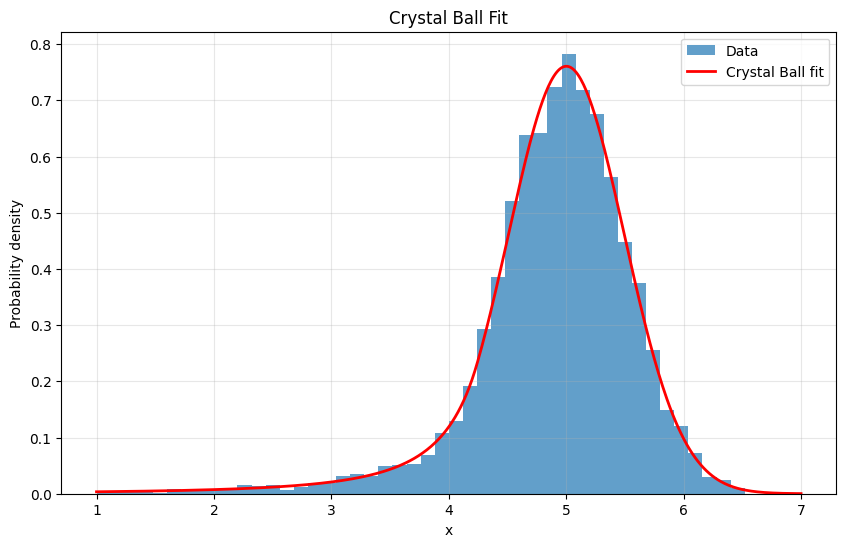


True values:  alpha=1.5, n=3.0, mu=5.0, sigma=0.5
Fitted values: alpha=1.544, n=2.692, mu=5.002, sigma=0.493


In [8]:
# Plot the fit
plt.figure(figsize=(10, 6))

# Histogram of data
counts, edges, _ = plt.hist(data, range=(1,7), bins=50, density=True, alpha=0.7, label='Data')
centers = 0.5 * (edges[1:] + edges[:-1])

# Fit curve
x_plot = np.linspace(1, 7, 500)
plt.plot(x_plot, cb_fit(x_plot), 'r-', linewidth=2, label='Crystal Ball fit')

plt.xlabel('x')
plt.ylabel('Probability density')
plt.title('Crystal Ball Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTrue values:  alpha={true_alpha}, n={true_n}, mu={true_mu}, sigma={true_sigma}")
print(f"Fitted values: alpha={alpha_fit.value:.3f}, n={n_fit.value:.3f}, mu={mu_fit.value:.3f}, sigma={sigma_fit.value:.3f}")